# Todo

* Make decent vanilla classifier
     * ~~Resize instead of cropping~~
     * Stop using new_whale as class
* Make siamese model
* Optimize image size
* Optimize dupilcate detector
* Optimize augmentation
* ~~Optimize tail detector and crop~~
    * ~~Use ResNext50 as opposed to ResNet34~~
    * ~~Add more data from other kaggle users~~

# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
from pathlib import Path

# Set up model

In [12]:
!ls

base2_submission.csv  Hashing.ipynb			  vgg16bn.py
base_submission.csv   lr_utils				  vgg16.py
CVxTz.ipynb	      __pycache__			  whales.ipynb
duplicates.csv	      Simple classifier in pytorch.ipynb
fastai		      Tail Cropping.ipynb


In [5]:
#PATH= 'D:/msc/kaggle_data/whales/'
PATH= Path('../../kaggle/whales')
SUBM_PATH = PATH/'submissions'

In [6]:
model=resnext50
bs=64
sz=299

In [13]:
def get_data(sz):
    tfms = tfms_from_model(model, sz, crop_type=CropType.NO, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH,'trn_val_cropped', PATH/'train.csv', bs=bs, tfms=tfms, test_name='test')

In [14]:
learn = ConvLearner.pretrained(model, get_data(sz))

In [9]:
learn.lr_find()

 95%|█████████▌| 133/140 [03:10<00:10,  1.43s/it, loss=66]  

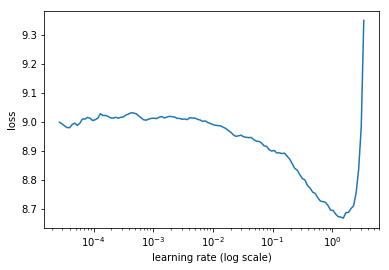

In [10]:
learn.sched.plot(n_skip_end=2)

In [11]:
lr=2e-1

In [12]:
learn.fit(lr,3, cycle_len=1, cycle_mult=2)

  0%|          | 0/140 [00:00<?, ?it/s]                   


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      7.98365    6.33151    0.225664  
    1      7.246152   5.406034   0.24115                    
    2      5.76022    4.75439    0.279867                   
    3      6.159894   5.106066   0.21792                    
    4      4.7506     4.8023     0.279867                   
    5      3.108228   4.161307   0.341814                   
    6      2.131477   4.007778   0.35177                    



[array([4.00778]), 0.35176991150442477]

In [13]:
learn.save('sz299_bs128_lr2en1_ll_nocrop_updlib')
#learn.load('sz299_bs64_lr01_ll_nocrop')

In [11]:
lrs = np.array([lr/9,lr/3,lr])

In [12]:
learn.unfreeze()
learn.fit(lrs,3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      7.874274   6.331018   0.221239  
    1      7.740196   5.982207   0.22677                                                                               
    2      7.633639   5.883034   0.224558                                                                              
    3      7.592475   5.718005   0.228982                                                                              
    4      7.519968   5.48413    0.234513                                                                              
    5      7.227295   5.401085   0.22677                                                                               
    6      7.435877   5.36484    0.230088                                                                              



[5.364840196297232, 0.23008849557522124]

In [14]:
#learn.save('299_full_nocrop')
learn.load('299_full_nocrop')

# Submit

## Run predictor

In [30]:
log_probs,_ = learn.TTA(is_test=True)

In [32]:
probs = np.mean(np.exp(log_probs),0)

In [33]:
best_pred_numbers = np.argsort(-probs,1)[:,:5]

In [34]:
lookup_names = np.vectorize(lambda i: learn.data.classes[i])
best_pred_names = lookup_names(best_pred_numbers)

In [35]:
filenames = np.array([fn[5:] for fn in learn.data.test_ds.fnames]).reshape(-1,1)

## Fix duplicates

In [36]:
duplicates_df = pd.read_csv('duplicates.csv')

In [37]:
for i in range(len(duplicates_df)):
    findex = np.where(filenames == duplicates_df.iloc[i]['file'])[0][0]
    best_pred_names[findex,:] = np.concatenate([np.array(list(eval(duplicates_df.iloc[i]['names']))), best_pred_names[findex,:]])[:5]

In [38]:
best_pred_names[:7]

array([['w_01b2250', 'w_fd1cb9d', 'new_whale', 'w_4f38350', 'w_64f3545'],
       ['w_3694c7d', 'new_whale', 'w_5a2075e', 'w_3694c7d', 'w_aef3680'],
       ['new_whale', 'w_71e6583', 'w_6dbb861', 'w_e3c119c', 'w_48a5b86'],
       ['w_a59905f', 'new_whale', 'w_4855bd3', 'w_a22f338', 'w_43be268'],
       ['w_44f0fa2', 'w_44f0fa2', 'w_6c803bf', 'w_8d83172', 'w_e02fe7b'],
       ['new_whale', 'w_2cca6a1', 'w_ee948c6', 'w_af890ad', 'w_8a3449f'],
       ['new_whale', 'w_e685c80', 'w_4e52a49', 'w_711aaa1', 'w_8d46cef']], dtype='<U9')

## Submit

In [39]:
subm = np.concatenate([filenames, best_pred_names], axis = 1)
name = 'subm_resnext50_sz299_bs64_lr01_ll_nocrop.csv'
np.savetxt(name, subm, fmt = '%s, %s %s %s %s %s', header = 'Image,Id', comments = '')